In [1]:
import numpy as np
from matplotlib import pyplot as plt
from numba import jit
import imageio
import cProfile

In [2]:
def sea_plot(sea, i):
    L = len(sea)
    p_matrix = np.zeros((L, L))
    p_matrix[sea[:, :, 0]>=1] = 1
    p_matrix[sea[:, :, 0]<=-1] = 0
    p_matrix[sea[:, :, 0]==0] = -1
    plt.clf()
    plt.imshow(p_matrix, cmap='jet')
    plt.savefig(f'img{i:06d}.png', dpi=200)

@jit(nopython=True)
def fish_move(x, y, sea, fish_rep):
    L = len(sea)
    points = [(x, (y+1)%L, 0), (x, (y-1)%L, 0), ((x-1)%L, y, 0), ((x+1)%L, y, 0)]
    pfree = []
    for p in points:
        if sea[p] == 0:
            pfree.append(p)
    if not pfree:
        return
    i = int(np.random.rand()*len(pfree))
    if sea[x, y, 0] ==-1:
        sea[pfree[i]] = -fish_rep
        sea[x, y, 0] = -fish_rep
    else:
        sea[pfree[i]] = sea[x, y, 0] + 1
        sea[x, y, 0] = 0      

@jit(nopython=True)
def shark_move(x, y, sea, shark_rep, shark_E):
    L = len(sea)
    points = [(x, (y+1)%L, 0), (x, (y-1)%L, 0), ((x-1)%L, y, 0), ((x+1)%L, y, 0)]
    pfree = []
    pfish = []
    for p in points:
        if sea[p] < 0:
            pfish.append(p)
    if pfish:
        i = int(np.random.rand()*len(pfish))
        if sea[x, y, 0] == 1:
            sea[pfish[i]] = shark_rep
            sea[x, y, 0] = shark_rep
            sea[pfish[i][0], pfish[i][1], 1] = shark_E
            sea[x, y, 1] = shark_E
        else:
            sea[pfish[i]] = sea[x, y, 0] - 1
            sea[pfish[i][0], pfish[i][1], 1] = shark_E
            sea[x, y, :] = 0  
    else:
        for p in points:
            if sea[p] == 0:
                pfree.append(p)
        if not pfree:
            return
        i = int(np.random.rand()*len(pfree))
        if sea[x, y, 0] == 1:
            sea[pfree[i]] = shark_rep
            sea[x, y, 0] = shark_rep
            sea[pfree[i][0], pfree[i][1], 1] = sea[x, y, 1] -1
            sea[x, y, 1] = shark_E
        else:
            sea[pfree[i]] = sea[x, y, 0] - 1
            sea[pfree[i][0], pfree[i][1], 1] = sea[x, y, 1] - 1
            sea[x, y, :] = 0
        if sea[pfree[i][0], pfree[i][1], 1] == 0:
            sea[pfree[i][0], pfree[i][1], :] = 0


@jit(nopython=True)
def evolve(sea, fish_rep, shark_rep, shark_E):
    xs, ys = np.nonzero(sea[:, :, 0])
    for n in range(len(xs)):
        x = xs[n]
        y = ys[n]
        if sea[x, y, 0]<0:
            fish_move(x, y, sea, fish_rep)
        elif sea[x, y, 0]>0:
            shark_move(x, y, sea, shark_rep, shark_E)


@jit(nopython=True)
def foo(sea, fish_rep, shark_rep, shark_E, T):
    res = []
    for t in T:
        evolve(sea, fish_rep, shark_rep, shark_E)
        res.append(np.copy(sea))
    return res


In [3]:

L = 40

shark_E = 3
fish_rep = 3
shark_rep = 20
shark_N = 10
fish_N = 300

sE = np.random.randint(1, shark_E+1, shark_N)
srep = np.random.randint(1, shark_rep+1, shark_N)
sx = np.random.randint(0, L, shark_N)
sy = np.random.randint(0, L, shark_N)

frep = np.random.randint(1, fish_rep+1, fish_N)
fx = np.random.randint(0, L, fish_N)
fy = np.random.randint(0, L, fish_N)


sea = np.zeros((L, L, 2))

sea[fx, fy, 0] = -frep #ryby ujemne 
sea[sx, sy, 0] = srep #rekiny dodatnie
sea[sx, sy, 1] = sE


T = np.arange(1000)

res = foo(sea, fish_rep, shark_rep, shark_E, T)


In [97]:

L = 200

shark_E = 3
fish_rep = 3
shark_rep = 20
shark_N = 15*25
fish_N = 250*25

sE = np.random.randint(1, shark_E+1, shark_N)
srep = np.random.randint(1, shark_rep+1, shark_N)
sx = np.random.randint(0, L, shark_N)
sy = np.random.randint(0, L, shark_N)

frep = np.random.randint(1, fish_rep+1, fish_N)
fx = np.random.randint(0, L, fish_N)
fy = np.random.randint(0, L, fish_N)


sea = np.zeros((L, L, 2))

sea[fx, fy, 0] = -frep #ryby ujemne 
sea[sx, sy, 0] = srep #rekiny dodatnie
sea[sx, sy, 1] = sE


T = np.arange(300)

res = foo(sea, fish_rep, shark_rep, shark_E, T)

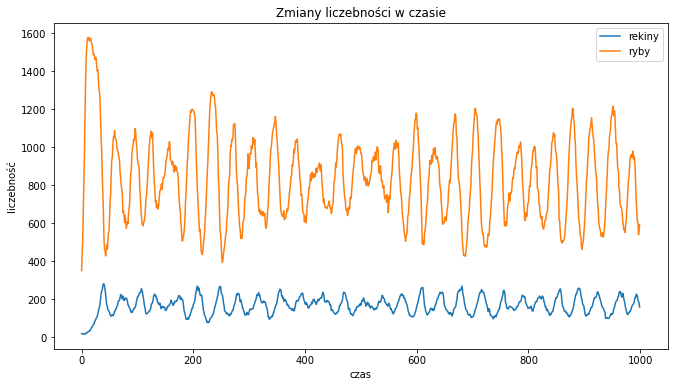

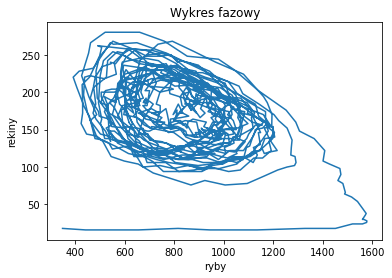

In [11]:
sharks = []
fish = []

for i, l in enumerate(res):
    #sea_plot(l, i)
    sharks.append(len(l[l>0]))
    fish.append(len(l[l<0]))

plt.clf()
f = plt.gcf()
f.set_size_inches((11, 6))
plt.plot(T, sharks, label="rekiny")
plt.plot(T, fish, label = 'ryby')
plt.xlabel("czas")
plt.ylabel("liczebność")
plt.title("Zmiany liczebności w czasie")
plt.legend()
plt.show()

plt.clf()
plt.plot(fish, sharks)
plt.xlabel("ryby")
plt.ylabel("rekiny")
plt.title("Wykres fazowy")
plt.show()

# filenames = [f'img{i:06d}.png' for i in T]
# with imageio.get_writer('movie_200.gif', mode='I') as writer:
#     for filename in filenames:
#         image = imageio.imread(filename)
#         writer.append_data(image)

In [ ]:
def sea_plot(sea, i):
    L = len(sea)
    p_matrix = np.zeros((L, L))
    p_matrix[sea[:, :, 0]>=1] = 1
    p_matrix[sea[:, :, 0]<=-1] = 0
    p_matrix[sea[:, :, 0]==0] = -1
    plt.clf()
    plt.imshow(p_matrix, cmap='jet')
    plt.savefig(f'img{i:06d}.png', dpi=200)

@jit(nopython=True)
def fish_move(x, y, sea, fish_rep):
    L = len(sea)
    points = [(x, (y+1)%L, 0), (x, (y-1)%L, 0), ((x-1)%L, y, 0), ((x+1)%L, y, 0)]
    pfree = []
    for p in points:
        if sea[p] == 0:
            pfree.append(p)
    if not pfree:
        return
    i = int(np.random.rand()*len(pfree))
    if sea[x, y, 0] ==-1:
        sea[pfree[i]] = -fish_rep
        sea[x, y, 0] = -fish_rep
    else:
        sea[pfree[i]] = sea[x, y, 0] + 1
        sea[x, y, 0] = 0      

@jit(nopython=True)
def shark_move(x, y, sea, shark_rep, shark_E):
    L = len(sea)
    points = [(x, (y+1)%L, 0), (x, (y-1)%L, 0), ((x-1)%L, y, 0), ((x+1)%L, y, 0)]
    pfree = []
    pfish = []
    for p in points:
        if sea[p] < 0:
            pfish.append(p)
    if pfish:
        i = int(np.random.rand()*len(pfish))
        if sea[x, y, 0] == 1:
            sea[pfish[i]] = shark_rep
            sea[x, y, 0] = shark_rep
            sea[pfish[i][0], pfish[i][1], 1] = shark_E
            sea[x, y, 1] = shark_E
        else:
            sea[pfish[i]] = sea[x, y, 0] - 1
            sea[pfish[i][0], pfish[i][1], 1] = shark_E
            sea[x, y, :] = 0  
    else:
        for p in points:
            if sea[p] == 0:
                pfree.append(p)
        if not pfree:
            return
        i = int(np.random.rand()*len(pfree))
        if sea[x, y, 0] == 1:
            sea[pfree[i]] = shark_rep
            sea[x, y, 0] = shark_rep
            sea[pfree[i][0], pfree[i][1], 1] = sea[x, y, 1] -1
            sea[x, y, 1] = shark_E
        else:
            sea[pfree[i]] = sea[x, y, 0] - 1
            sea[pfree[i][0], pfree[i][1], 1] = sea[x, y, 1] - 1
            sea[x, y, :] = 0
        if sea[pfree[i][0], pfree[i][1], 1] == 0:
            sea[pfree[i][0], pfree[i][1], :] = 0


@jit(nopython=True)
def evolve(sea, fish_rep, shark_rep, shark_E):
    xs, ys = np.nonzero(sea[:, :, 0])
    for n in range(len(xs)):
        x = xs[n]
        y = ys[n]
        if sea[x, y, 0]<0:
            fish_move(x, y, sea, fish_rep)
        elif sea[x, y, 0]>0:
            shark_move(x, y, sea, shark_rep, shark_E)


@jit(nopython=True)
def foo(sea, fish_rep, shark_rep, shark_E, T):
    res = []
    for t in T:
        evolve(sea, fish_rep, shark_rep, shark_E)
        res.append(np.copy(sea))
    return res


L = 40

shark_E = 3
fish_rep = 3
shark_rep = 20
shark_N = 10
fish_N = 300

sE = np.random.randint(1, shark_E+1, shark_N)
srep = np.random.randint(1, shark_rep+1, shark_N)
sx = np.random.randint(0, L, shark_N)
sy = np.random.randint(0, L, shark_N)

frep = np.random.randint(1, fish_rep+1, fish_N)
fx = np.random.randint(0, L, fish_N)
fy = np.random.randint(0, L, fish_N)


sea = np.zeros((L, L, 2))

sea[fx, fy, 0] = -frep #ryby ujemne 
sea[sx, sy, 0] = srep #rekiny dodatnie
sea[sx, sy, 1] = sE


T = np.arange(1000)

res = foo(sea, fish_rep, shark_rep, shark_E, T)

sharks = []
fish = []

for i, l in enumerate(res):
    #sea_plot(l, i)
    sharks.append(len(l[l>0]))
    fish.append(len(l[l<0]))

plt.clf()
f = plt.gcf()
f.set_size_inches((11, 6))
plt.plot(T, sharks, label="rekiny")
plt.plot(T, fish, label = 'ryby')
plt.xlabel("czas")
plt.ylabel("liczebność")
plt.title("Zmiany liczebności w czasie")
plt.legend()
plt.show()